In [9]:
# !pip3 install scikit-learn termcolor

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn as skl
from termcolor import colored

# Classification

Suppose we have a set of objects, described by their features $x^{(k)}$, and labels $l^{(k)}$ assigned to the objects.
Doing statistical classification we find the rule $f$ that maps $x^{(k)}$ to $l^{(k)}$ and generalize the rule to all possible objects.
For example, given samples of handwritten digits, problem of statistical classification is to assign the correct digit to an arbitrary character.

From mathematical point of view, the classifier $f$ is a mapping from the vector space $\mathbb R^N$ of all features $x$  to the vector space $\mathbb R^M$ of scores $p$, where $N$ is the number of features, and $M$ is the number of classes. In the simplest case the output of the classifier can be the class/label $l$ itself, but usage of scores instead of labels have several benefits: (1) the score shows confidence in the result, (2) scores are differentiable what is a desirable property for machine learning, (3) cross-entropy loss function can be used. 
It is convenient to consider score $p_l$ as the probability of $x$ to belong to the class $l$, therefore $p$ should be properly normalized: 
$p_l\geq 0$, $\sum_l p_l=1$.

In ML the classifier $f(\cdot|\theta)$ is taken from a predefined set, chosen to match known properties of the problem. 
Then the parameters $\theta$ of the classifier are tuned to match the training set $x^{train,k}$, $p^{train,k}$ in the best possible way.
Two method are most popular for training the classifier: (1) point estimation of $\theta$, e.g. maximum likelyhood method, and (2) Bayesian inference capable of estimation of probability distribution of $\theta$.

## Point estimation

Suppose $f(x|\theta)=p$ is the probability destribution of $x$ to belong to each class for specified parameters $\theta$ pf the classifier.
If the exact distribution is known, denote it by $\hat p(x)$, than the performance of the classifier can be estimated by the cross entropy function:
$$
H(p,\hat p)=-\sum_l p_l\log \hat p(x)_l.
$$
In applications the distribution is rarely known, instead samples $l^{k}$ of $p(x)$ are known.
In the case the cross entropy can be estimated by the following statistics:
$$
H(p,\hat p)\approx -S^{-1}\sum_k \log \hat p(x)_{l^{(k)}},
$$ 
where $S$ is total number of samples.
To estimate the performance of the estimate $\theta$ on all objects $x$, 
an averaging over all $x$ is applied, 
$$
E_x[H|\theta]\approx L[x,y|\theta]=-S^{-1}\sum_k \log \hat p(x^{(k)})_{l^{(k)}}. 
$$
The training of the classifier is just minimization of the loss function on the training set:
$$
\hat\theta = \mathrm{argmin}_\theta L[x^{train,k}|\theta), y^{train,k}|\theta].
$$



One of the simplest classifiers is linear classifier. Assume that there are only two possible classes for $x$ to belong to. 
Than the distribution $p$ is defined by the single value $p_0\in[0,1]$ defining the probability of $x$ to belong to the class $0$.
The linear classifier assumes that classes are separated by a hyperplane, therefore the score is computed by:
$$
p_0(x|\theta)=f(x\cdot\theta)=f(\sum_j x_j \theta_j),
$$
where common choice for the activatio function $f$ are step function and logistic function:
$$
f(a)=(1+e^{-x})^{-1}.
$$
Applying a fixed non-linear tranform $T$ to the points $x$ before evaluation of the inner product,
$$
p_0(x|\theta)=f(T(x)\cdot\theta)=f(\sum_j T(x)_j \theta_j),
$$
effectively transforms the dividing hyperplane to arbitrary complex hypersurface, 
thus hugely increasing class of the problems solvable by the linear regression.
The transform $T$ can even map every element $x$ to several features, e.g. polynomial basis,
allowing reconstruction of almost arbitrary dependence in data.
Increasing number of features can potentialy significantly slow down computation,
but [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) can be used to even infinite number of features without overhead.




## Performance metrics

Performance of the classifier can be estimated using [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) 
and derived metrics such as [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) for binary classifiers.
The metrics can be misleading, if the data is unbalanced, that is if numbers of postive and negative cases are significantly different. 

If a classifier returns score for each class, than boundary between classes are determined by the threshold value. 
The best possible value can be estimated from [Receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic),
which is dependence of true positive cases on false positive. 
The best threshold corresponds to upper left point on the plot.
The area under the ROC curve is also used to compare different classifiers.


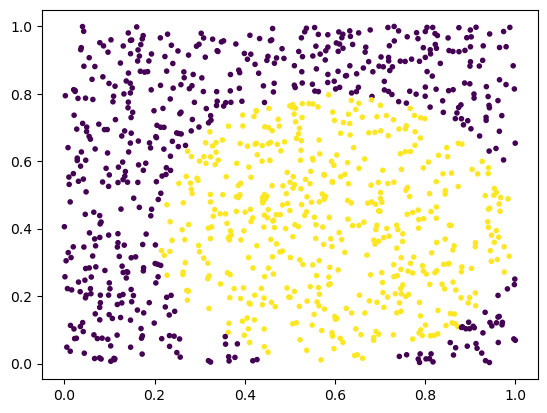

In [2]:
def visualize(x=None, y=None, y_predicted=None, axis=None):
    nitems = x.shape[0]
    # assert y.shape == (nitems,)  
    # assert x.ndim == 2 

    # if y_predicted is not None:
    #     assert y_predicted.shape == y.shape
    #     wrong_predictions = y!=y_predicted
    # else:
    wrong_predictions = slice(0)
    
    if axis is None:
        _fig, axis = plt.subplots()
        
    if x.shape[1] == 2: # Scatter plot vizualization
        axis.scatter(x=x[wrong_predictions,0], y=x[wrong_predictions,1], c='r', marker=',')
        axis.scatter(x=x[:,0], y=x[:,1], c=y, marker='.')
    else: # Function plot
        axis.plot(x[wrong_predictions,:], c='r', linestyle='solid', linewidth=3)
        axis.plot(x[y==0,:].T, c='y', linestyle='solid')
        axis.plot(x[y==1,:].T, c='b', linestyle='solid')        
        
        

class TestProblem:
    def sample(self, nitems: int):
        raise NotImplementedError

    def visualize(self, nitems=1000, axis=None):
        x, y = self.sample(nitems=nitems)
        visualize(x=x, y=y, axis=axis)

class CircleProblem(TestProblem):
    def __init__(self, center: np.ndarray, radius: float):
        self._center = np.array(center)
        assert self._center.ndim == 1
        self._radius = np.float32(radius)

    def sample(self, nitems):
        x = np.random.rand(nitems, self._center.shape[0])
        distance_to_the_center = np.linalg.norm(x-self._center[None], ord=2, axis=-1)
        y = distance_to_the_center<self._radius
        return x, y

problem = CircleProblem(center=(0.6, 0.4), radius=0.4)
problem.visualize()
plt.show()



In [3]:
from sklearn import metrics

def confusion_matrix(y, y_predicted):
    mx = np.maximum(np.max(y),np.max(y_predicted))
    confusion_matrix = np.zeros((mx+1, mx+1), dtype=np.int32)
    for r, c in zip(y,y_predicted):
        confusion_matrix[r,c] += 1
    return confusion_matrix

def print_metrics(y, y_predicted):
    y = np.array(y, dtype=np.int8)
    y_predicted = np.array(y_predicted, dtype=np.int8)
    
    cm = confusion_matrix(y,y_predicted)
    print(f"Confusion matrix:\n", cm)

    if cm.shape[0]==2:
        (TP, FN), (FP, TN) = cm
        recall = TP/(TP+FN)
        precision = TP/(TP+FP)
        f1 = 2*TP/(2*TP+FP+FN)
        print(f"Recall {100*recall:.2f}%, precision {100*precision:.2f}%, f1-measure {100*f1:.2f}%")

def benchmark_classifier(clf, problem, x_tr, y_tr, x_t, y_t, n_training_samples=1000, n_test_samples=100):
    # training_x, training_y = problem.sample(x_tr, y_tr, nitems=n_training_samples)
    # test_x, test_y = problem.sample(x_t, y_t, nitems=n_test_samples)
    training_x = x_tr
    training_y = y_tr
    
    test_x = x_t
    test_y = y_t

    clf.fit(training_x, training_y)

    y_predicted = clf.predict(training_x)
    y_predicted_test = clf.predict(test_x)

    print(colored("Training data:","yellow"))
    print_metrics(training_y, y_predicted)

    print("Test data:")
    print_metrics(test_y, y_predicted_test)


    fig, (axis1, axis2, axis3) = plt.subplots(ncols=3, figsize=(15, 5))

    visualize(training_x, training_y, y_predicted, axis=axis1)
    axis1.set_title('Training set')

    visualize(test_x, test_y, y_predicted_test, axis=axis2)
    axis2.set_title('Test set')

    scores = clf.decision_function(test_x)
    fpr, tpr, thresholds = metrics.roc_curve(test_y, scores)
    axis3.plot(fpr, tpr)
    axis3.set_title('Receiver operating characteristic')

    plt.show()


In [6]:

from sklearn import svm
clf = svm.SVC()
benchmark_classifier(clf, problem)

TypeError: benchmark_classifier() missing 4 required positional arguments: 'x_tr', 'y_tr', 'x_t', and 'y_t'

## Problems:

1. `CircleProblem` above is an example of complete separation problem, that is a unique class is assigned deterministically to every features vector. In many cases however the boundary between the classes are blured or the classes overlap. That means that in general only probability distribution of the classes can be defined. 
As an example, consider a test binary classification problem `GaussProblem`, such that an object described by a vector from $\mathbb R^N$ belongs to the first (positives) class with the probability defined by the [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). The class of every object in the training/test is uniquely defined, despite the fact that the same object can belong to different classes on multiple occurances in the set. Define a class implementing the problem settings.

In [7]:
class GaussProblem(TestProblem):
    def __init__(self, center: np.ndarray, radius: float):
        self._center = np.array(center)
        assert self._center.ndim == 1
        self._radius = np.float32(radius)
        
    def score(self, points):
        assert points.ndim==2 and points.shape[1]==self._center.shape[0]
        distance_to_center_squared = np.sum( (points-self._center[None])**2, axis=-1)
        return np.exp(-distance_to_center_squared/(2*self._radius**2))

    def sample(self, x_data, y_data):
        # x = np.random.rand(nitems, self._center.shape[0])
        # zero_class_probability = self.score(x)
        # y = np.random.rand(nitems)<=zero_class_probability
        # zero_class_probability = self.score(x_data)
        return x_data, y_data

problem = GaussProblem(center=(0.6, 0.4), radius=0.25)
problem.visualize()
plt.show()

TypeError: GaussProblem.sample() got an unexpected keyword argument 'nitems'

In [8]:
clf = svm.SVC()
benchmark_classifier(clf, problem)

TypeError: benchmark_classifier() missing 4 required positional arguments: 'x_tr', 'y_tr', 'x_t', and 'y_t'

### 2

2. Размытие границы между классами приводит к возрастанию доли ложно-положительных и ложно-отрицательных предсказаний

### 3

3. Попробуем подобрать параметры классификатора, для решения проблемы

In [9]:
x_train = np.random.rand(1000, problem._center.shape[0])
zero_class_probability = problem.score(x_train)
y_train = np.random.rand(1000)<=zero_class_probability

x_t = np.random.rand(100, problem._center.shape[0])
zero_class_probability = problem.score(x_t)
y_t = np.random.rand(100)<=zero_class_probability

Training data:
Confusion matrix:
 [[537 104]
 [135 224]]
Recall 83.78%, precision 79.91%, f1-measure 81.80%
Test data:
Confusion matrix:
 [[52  8]
 [14 26]]
Recall 86.67%, precision 78.79%, f1-measure 82.54%


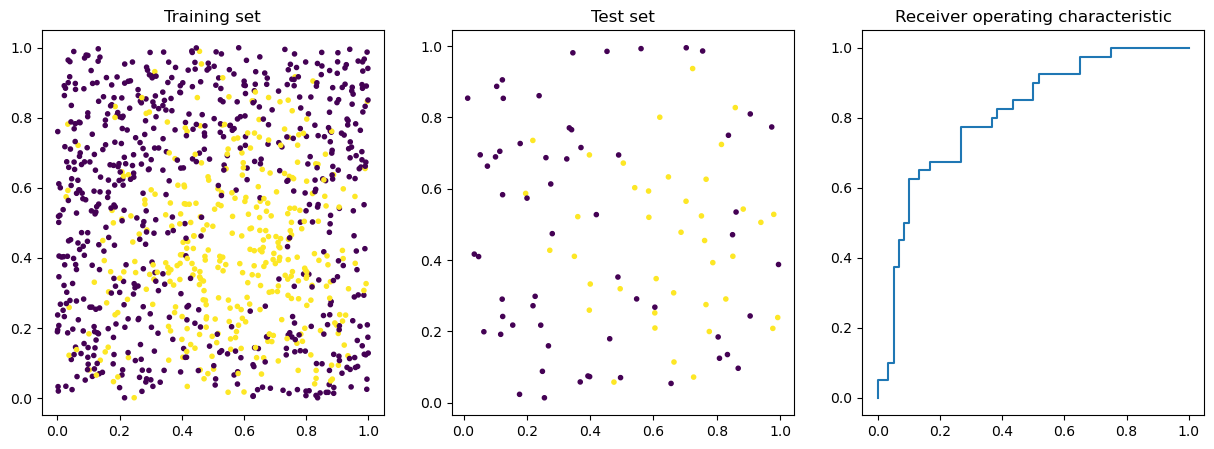

In [10]:
clf = svm.SVC(gamma=2)
benchmark_classifier(clf, problem, x_train, y_train, x_t, y_t)

Training data:
Confusion matrix:
 [[572  69]
 [164 195]]
Recall 89.24%, precision 77.72%, f1-measure 83.08%
Test data:
Confusion matrix:
 [[54  6]
 [18 22]]
Recall 90.00%, precision 75.00%, f1-measure 81.82%


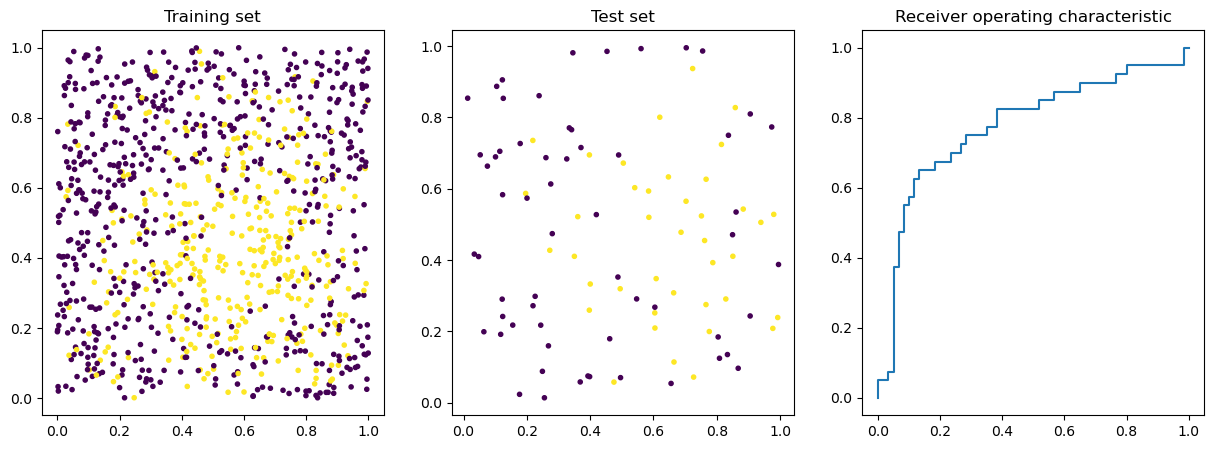

In [11]:
clf = svm.SVC()
benchmark_classifier(clf, problem, x_train, y_train, x_t, y_t)

### 4

Попробуем другие ядра SVC

Линейное ядро

Training data:
Confusion matrix:
 [[641   0]
 [359   0]]
Recall 100.00%, precision 64.10%, f1-measure 78.12%
Test data:
Confusion matrix:
 [[60  0]
 [40  0]]
Recall 100.00%, precision 60.00%, f1-measure 75.00%


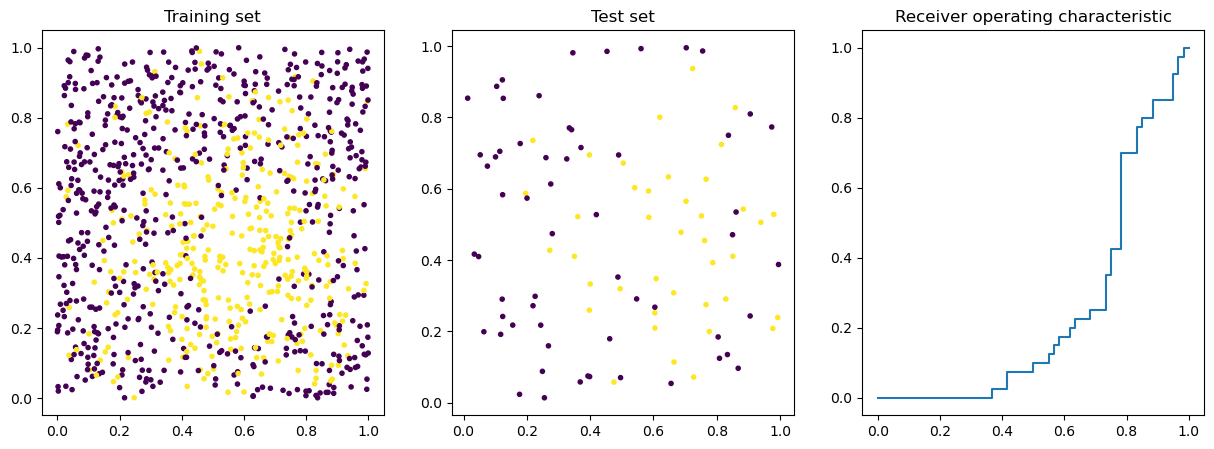

In [12]:
clf = svm.SVC(kernel='linear')
benchmark_classifier(clf, problem, x_train, y_train, x_t, y_t)

Полином

Training data:
Confusion matrix:
 [[509 132]
 [121 238]]
Recall 79.41%, precision 80.79%, f1-measure 80.09%
Test data:
Confusion matrix:
 [[50 10]
 [13 27]]
Recall 83.33%, precision 79.37%, f1-measure 81.30%


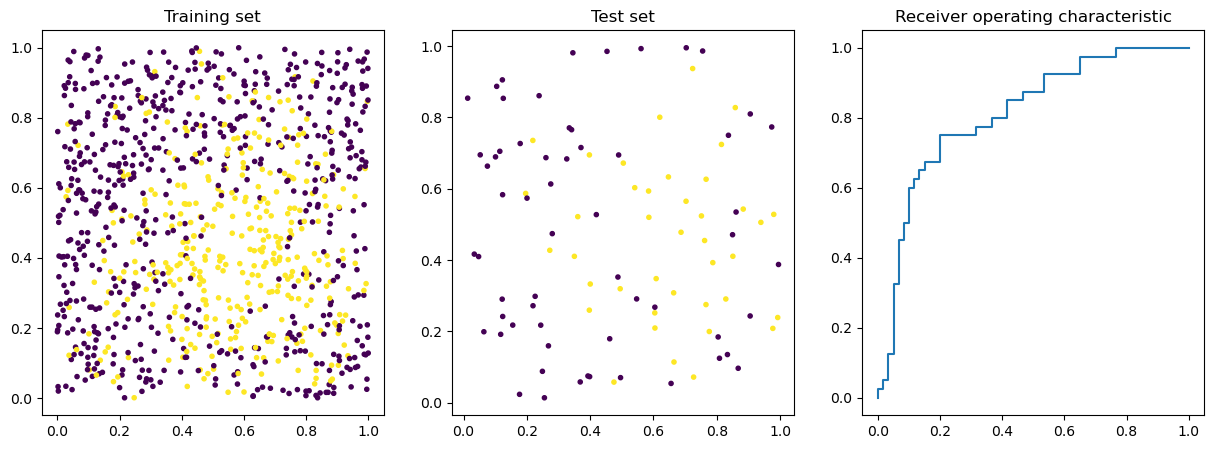

In [13]:
clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma=10)
benchmark_classifier(clf, problem, x_train, y_train, x_t, y_t)

Сигмоида

Training data:
Confusion matrix:
 [[535 106]
 [345  14]]
Recall 83.46%, precision 60.80%, f1-measure 70.35%
Test data:
Confusion matrix:
 [[53  7]
 [38  2]]
Recall 88.33%, precision 58.24%, f1-measure 70.20%


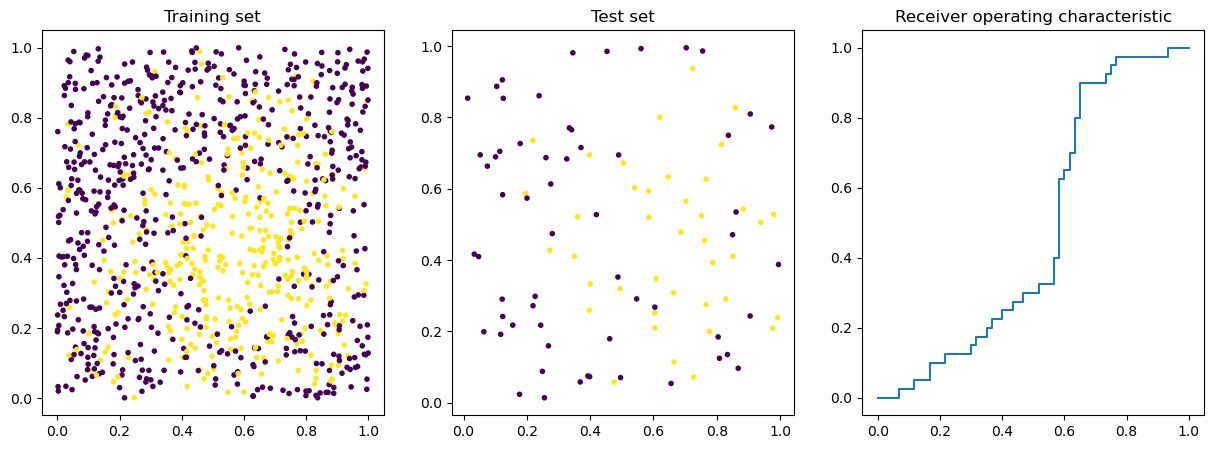

In [14]:
clf = svm.SVC(kernel='sigmoid', gamma=0.5, coef0=0.2)
benchmark_classifier(clf, problem, x_train, y_train, x_t, y_t)

### K-ближайших соседей

In [15]:
from sklearn import neighbors

In [18]:
def benchmark_kmean(clf, x_tr, y_tr, x_t, y_t):
    feature_num = x_tr.shape[-1]
    # training_x, training_y = problem.sample(x_tr, y_tr, nitems=n_training_samples)
    # test_x, test_y = problem.sample(x_t, y_t, nitems=n_test_samples)
    training_x = x_tr
    training_y = y_tr
    
    test_x = x_t
    test_y = y_t

    clf.fit(training_x, training_y)

    y_predicted = clf.predict(training_x)
    y_predicted_test = clf.predict(test_x)

    print(colored("Training data:","yellow"))
    print_metrics(training_y, y_predicted)

    print("Test data:")
    print_metrics(test_y, y_predicted_test)


    fig, (axis1, axis2, axis3) = plt.subplots(ncols=3, figsize=(15, 5))
    visualize(training_x[:,:2], training_y, y_predicted, axis=axis1)
    axis1.set_title('Training set')

    visualize(test_x[:,:2], test_y, y_predicted_test, axis=axis2)
    axis2.set_title('Test set')

    fpr, tpr, thresholds = metrics.roc_curve(test_y, y_predicted_test)
    axis3.plot(fpr, tpr)
    axis3.set_title('Receiver operating characteristic')

    plt.show()

Training data:
Confusion matrix:
 [[569  72]
 [124 235]]
Recall 88.77%, precision 82.11%, f1-measure 85.31%
Test data:
Confusion matrix:
 [[52  8]
 [15 25]]
Recall 86.67%, precision 77.61%, f1-measure 81.89%


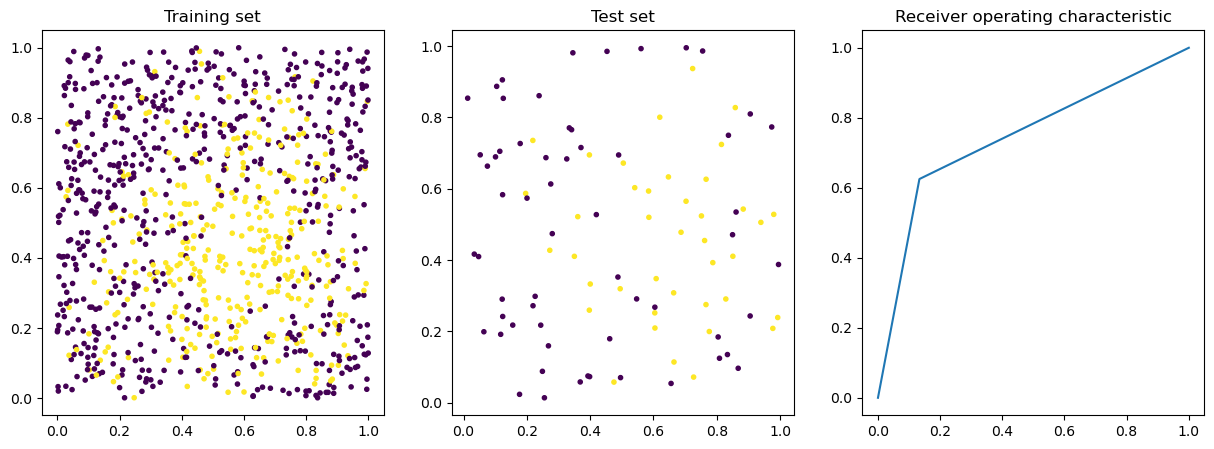

In [19]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
benchmark_kmean(clf, x_train, y_train, x_t, y_t)

### Random Forest

In [20]:
from sklearn import ensemble

Training data:
Confusion matrix:
 [[641   0]
 [  0 359]]
Recall 100.00%, precision 100.00%, f1-measure 100.00%
Test data:
Confusion matrix:
 [[50 10]
 [15 25]]
Recall 83.33%, precision 76.92%, f1-measure 80.00%


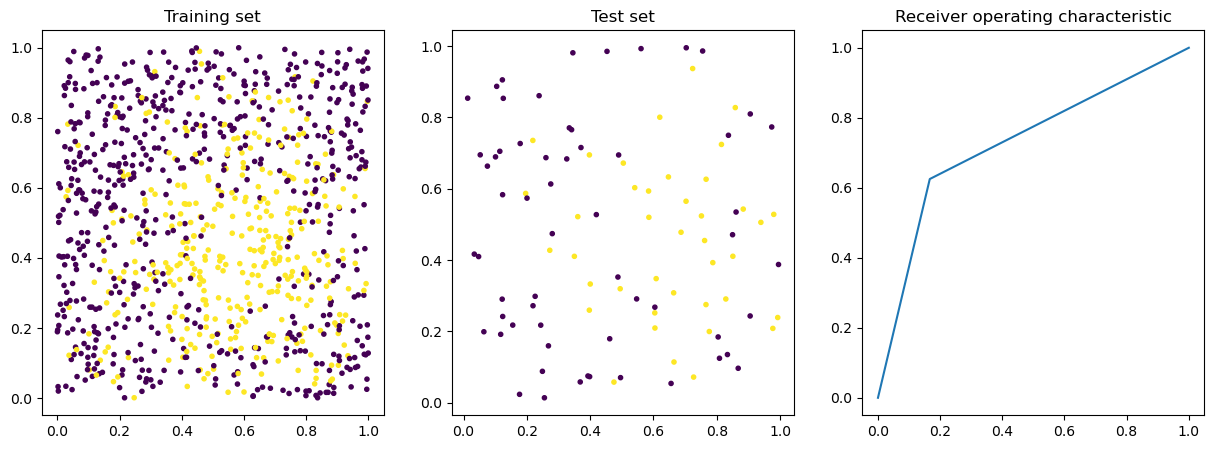

In [21]:
clf = ensemble.RandomForestClassifier()
benchmark_kmean(clf, x_train, y_train, x_t, y_t)

### Гауссовский процесс

In [22]:
from sklearn.gaussian_process import GaussianProcessClassifier

Training data:
Confusion matrix:
 [[556  85]
 [200 159]]
Recall 86.74%, precision 73.54%, f1-measure 79.60%
Test data:
Confusion matrix:
 [[48 12]
 [24 16]]
Recall 80.00%, precision 66.67%, f1-measure 72.73%


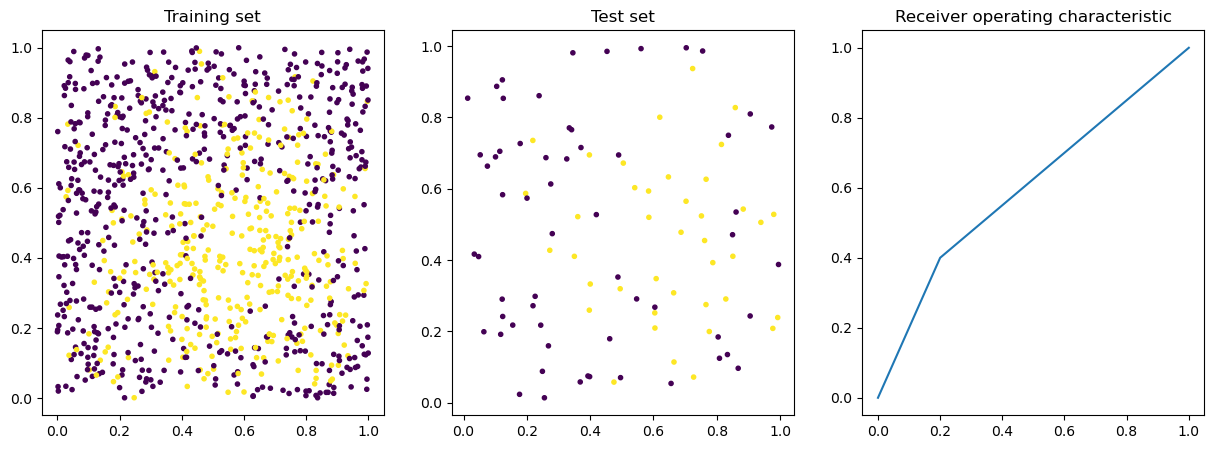

In [23]:
clf = GaussianProcessClassifier()
benchmark_kmean(clf, x_train, y_train, x_t, y_t)

### 5

Создадим генерацию выборки в виде эллипса

In [24]:
class EllipseProblem(TestProblem):
    def __init__(self, center: np.ndarray, a: float, b: float, angle: float):
        self._center = np.array(center)
        assert self._center.ndim == 1
        self._a = np.float32(a)
        self._b = np.float32(b)
        self._c = np.sqrt(self._a**2 - self._b**2)
        self._angle = np.float32(angle  )

    def sample(self, nitems, feature_num = 2):
        x = np.random.rand(nitems, self._center.shape[0])
        # distance_to_the_center = np.linalg.norm(x-self._center[None], ord=2, axis=-1)
        dist = (((x[:,0]-self._center[0])* np.cos(self._angle) + (x[:,1]-self._center[1])*np.sin(self._angle) )/self._a)**2 + ((-1*(x[:,0]-self._center[0])*np.sin(self._angle)+(x[:,1]-self._center[1])*np.cos(self._angle))/self._b)**2
        y = dist<1.0
        if feature_num > 2:
          y = np.reshape(y, (y.shape[0], 1))
          for i in range(feature_num - 2):
            x = np.hstack((x, np.random.rand(nitems, 1)))  
        return x, y

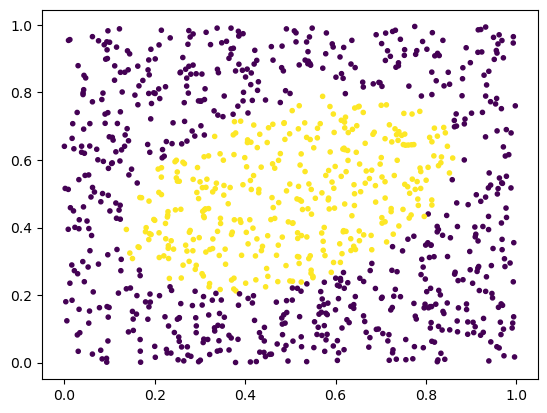

In [25]:
problem = EllipseProblem(center=(0.5, 0.5), a = 0.4, b = 0.25, angle=np.pi/6)
n = 1000
feature_num = 100
x, y = problem.sample(n, feature_num)
visualize(x[:,:2], y[:,0])

x_train = x[:int(n*0.7),:]
y_train = y[:int(n*0.7),:]

x_test = x[int(n*0.7):,:]
y_test = y[int(n*0.7):,:]

(700, 100)


c:\Users\roman\Anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training data:
Confusion matrix:
 [[363  93]
 [ 96 148]]
Recall 79.61%, precision 79.08%, f1-measure 79.34%
Test data:
Confusion matrix:
 [[130  69]
 [ 51  50]]
Recall 65.33%, precision 71.82%, f1-measure 68.42%


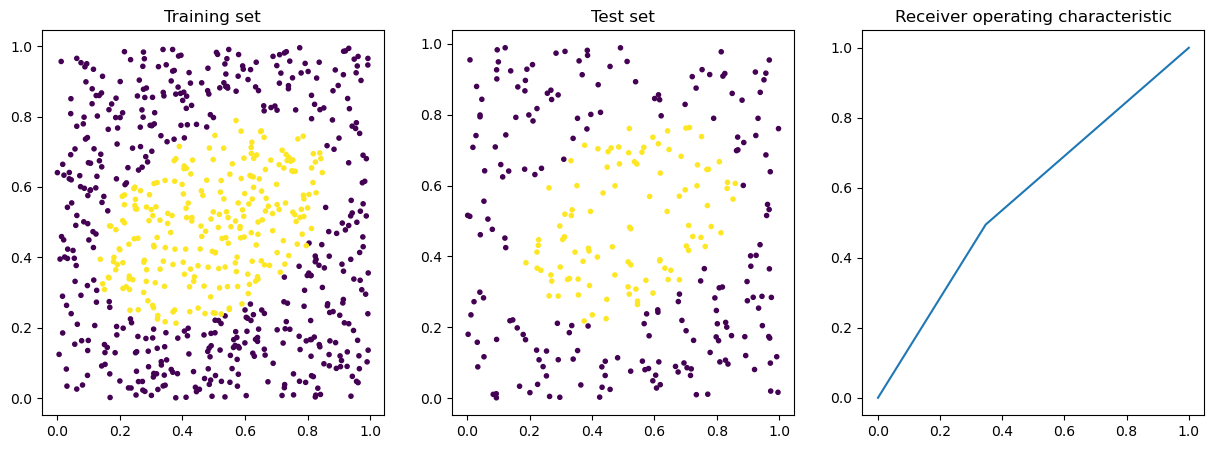

In [26]:
clf = neighbors.KNeighborsClassifier()
print(x_train.shape)
benchmark_kmean(clf, x_train, y_train, x_test, y_test)

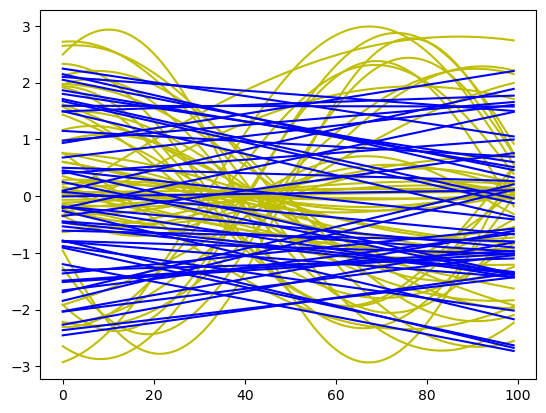

In [27]:
class FunctionProblem(TestProblem):
    def __init__(self, N: int):
        self._N = np.int32(N)
        assert self._N>0
        self._t = np.linspace(-.5,0.5,self._N)
     
    @property
    def t(self):
        return self._t
    
    def sample_zero_class(self, nitems):
        A = np.random.uniform(-3., 3., size=nitems)[:,None]
        B = np.random.uniform(0., 2*np.pi, size=nitems)[:,None]
        C = np.random.uniform(0., 1., size=nitems)[:,None]
        return A*np.sin(B*self.t[None]+C)
    
    def sample_first_class(self, nitems):
        D = np.random.uniform(-2., 2., size=nitems)[:,None]
        E = np.random.uniform(-2., 2., size=nitems)[:,None]
        return D*self.t[None]+E
    
        
    def sample(self, nitems):
        nitems0 = nitems//2
        nitems1 = nitems - nitems0
        x = np.concatenate((self.sample_zero_class(nitems0), self.sample_first_class(nitems1)), axis=0)
        y = np.concatenate((np.zeros(nitems0), np.ones(nitems1)), axis=0)
        assert x.shape == (nitems, self._N)
        assert y.shape == (nitems,)        
        perm = np.random.permutation(nitems)
        return x[perm], y[perm]
    
problem = FunctionProblem(N=100)
problem.visualize(100)
plt.show()

In [28]:
from sklearn.decomposition import PCA

In [29]:
x, y = problem.sample(100)
x_train = x[:int(100*0.7)]
y_train = y[:int(100*0.7)]

x_test = x[int(100*0.7):]
y_test = y[int(100*0.7):]

Определим число главных компонент

In [30]:
feat_num = x.shape[1]
var_ratio = np.zeros(feat_num)
for num in np.arange(1, feat_num + 1):
    pca = PCA(num)
    pca.fit(x)
    var_ratio[num - 1] = np.sum(pca.explained_variance_ratio_)

(0.0, 20.0)

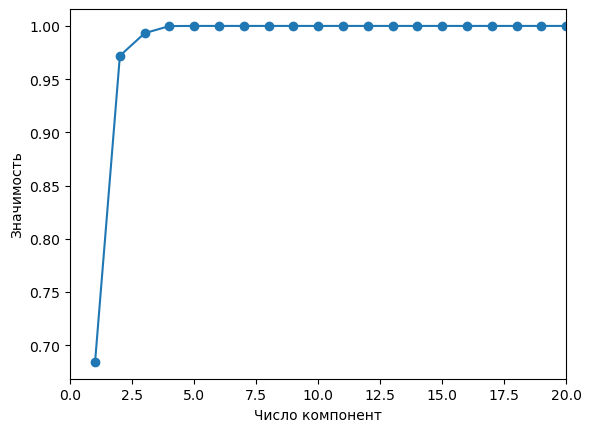

In [35]:
plt.plot(np.arange(1, feat_num + 1), var_ratio, '-o')
plt.xlabel('Число компонент')
plt.ylabel('Значимость')
plt.xlim(0, 20)

Виделим четыре главных компоненты

In [37]:
pca_x = PCA(n_components=4).fit_transform(x_train)

(70, 4)


2. Boundary between the classes in `GaussProblem` is blured in contrast to `CircleProblem`. How does the bluring affect classification metrics?

3. Check parameters of the classifiers and tune them to avoid overfitting.

4. Compare classifiers [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) impl, [k-nearest neighbors algorithm
](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), 
[`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) impl. [support-vector_machine](https://en.wikipedia.org/wiki/Support-vector_machine) with different kernels, 
[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) impl. [random forest method](https://ru.wikipedia.org/wiki/Random_forest)
from sklearn on `GaussProblem`, you may found usefull [this example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Explain difference in the performance of the classifiers.

5. Derive class `EllipseProblem` from `TestProblem` that generates plots of Ellipse. Increase dimensionality of the features space and use `KNeighborsClassifier`, do you see any effects of [curse of dimensionality?](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

6. Select [important features](https://en.wikipedia.org/wiki/Feature_selection) used by the classifier for `FunctionProblem`. Apply the [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) and visualize the result. Try to eliminate all features except of the important ones, and check performance of the classifier on the important features. Can you explain, how the classifier decides which class an example belongs to?